## PCA Tutorial with the Iris Dataset 

Justin Reising

### Introduction

Principal Component Analysis (PCA) is a simple, yet somewhat mysterious to novice users, and useful linear transformation technique that is used in numerous applications. The main goal of a PCA analysis is to identify patterns in data; PCA aims to detect the correlation between variables. If a strong correlation between variables exists, the attempt to reduce the dimensionality only makes sense.Finding the directions of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace while retaining most of the information.

### Main Goal: Dimensionality Reduction

One of the main ideas behind PCA is that items with similar characteristics should cluster. PCA is a method for compressing the data into something that captures the essence of the data without losing much information. (i.e significantly reducing the number of dimensions without losing much variance.)

Important question: How many dimensions can we reduce to that still represents the data "well"?

### PCA Approach

$\bullet$ Standardize the data.

$\bullet$ Obtain Eigenvectors and Eigenvalues from the covariance matrix or perform Singular Value Decomposition.

$\bullet$ Sort eigenvalues in descending order and choose $k$ eigenvectors that correspond to the $k$ largest eigenvalues where $k$ is the number of dimensions of the new feature subspace.

$\bullet$  Construct the projection matrix $\textbf{W}$ from the selected $k$ eigenvectors.

$\bullet$ Transform the original dataset $\textbf{X}$ via $\textbf{W}$ to obtain the $k$-dimensional feature subspace $\textbf{Y}$.


### Preparing the Data

In [2]:
import pandas as pd

df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',')

df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how="all", inplace=True) # drops the empty line at file-end

df.tail()

,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


Now we want to split our dataframe into two different arrays, one, a matrix with the values for sepal length, sepal width, petal length, and petal width as the columns, and the other, a vector for the class labels.

In [3]:
X = df[['sepal_len','sepal_wid','petal_len','petal_wid']].values
y = df['class'].values

### Exploratory Visualization

Now, lets investigate how the 3 different flower classes are distributed along the 4 different features with histograms.

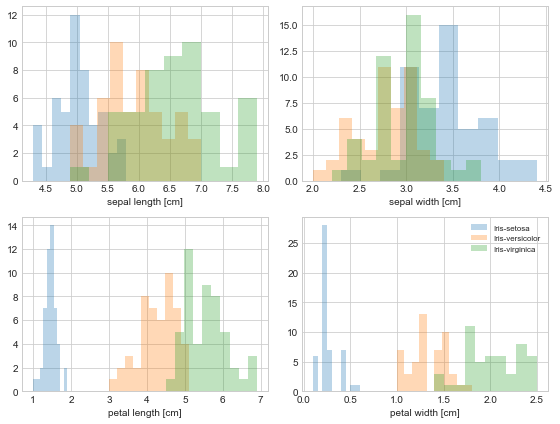

In [40]:
from matplotlib import pyplot as plt
import numpy as np
import math

label_dict = {1: 'Iris-Setosa',
              2: 'Iris-Versicolor',
              3: 'Iris-Virgnica'}

feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for cnt in range(4):
        plt.subplot(2, 2, cnt+1)
        for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
            plt.hist(X[y==lab, cnt],
                     label=lab,
                     bins=10,
                     alpha=0.3,)
        plt.xlabel(feature_dict[cnt])
    plt.legend(loc='upper right', fancybox=True, fontsize=8)

    plt.tight_layout()
    plt.show()

In the plots above, we can see significant overlap between flower classes for sepal length and sepal width. However there are separations between flower classes for petal length and petal width. 

### Standardizing the Data

Standardizing the data prior to PCA is important because if the data is in different units (say cm, meters, or inches) then the covariance matrix depends on these measurments. Many data sets contain features that are measured in different units that are dependent on the feature itself. Note that PCA solvers in Python and R have arguments to indicate whether you are using the Covariance Matrix or the Correlation Matrix. We will see that standardizing the data prior to calculating the covariance matrix is the same as using the correlation matrix, as it is a unitless. Although, all features in the Iris dataset were measured in centimeters, let us continue with the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms. 

In [5]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

### Eigendecomposition

The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the “core” of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

### Covariance Matrix

The classic approach to PCA is to perform the eigendecomposition on the covariance matrix $\Sigma$, which is a $d×d$ matrix where each element represents the covariance between two features. The calculation of the covariance matrix is as follows:

$\Sigma = \frac{1}{n-1} ((\textbf{X} - \bar{\textbf{x}})^{T}(\textbf{X} - \bar{\textbf{x}}))$ where $\bar{\textbf{x}} = \frac{1}{n}\sum_{i=1}^{n}x_{i}$

In [6]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


Similarly, we can use a NumPy function to carry out this calculation as well...

In [7]:
print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

NumPy covariance matrix: 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


Since we aim to identify the Principal Components, we need to extract the eigenvectors from the Covariance matrix of the standardized values of our matrix $\textbf{X}$.

In [8]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.93035378 0.92740362 0.14834223 0.02074601]


### Correlation Matrix

As mentioned before, the eigendecomposition of the correlation matrix yields the same result as the eigendecomposition of the pre-standardized covariance matrix. One can verify the equality of the decompositions with the covariance matrix above and the correlation matrix below.

In [9]:
cor_mat2 = np.corrcoef(X.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat2)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.91081808 0.92122093 0.14735328 0.02060771]


An important thing to note here is that since we are decomposing the standardized covariance or correlation matrix, then the eigenvectors form an orthonormal basis. (Which is demonstrated below) Where the dot product of different eigenvectors = 0 and the dot product of the same eigenvectors = 1. Interestingly enough, when we look at the correlation matrix, we have some significant correlations while the eigenvectors are all orthogonal. (Which are our Principal Components) This is what helps us achieve our goal of dimensionality reduction!

In [10]:
eig_vecs[:,1] @ eig_vecs[:,1]

1.0

In [11]:
eig_vecs[:,0] @ eig_vecs[:,2] #practically zero

7.771561172376096e-16

The orthogonality of the eigenvectors of the correlation matrix is what drives the utility of the Singular Value Decomposition (SVD) for applications in PCA.

$\textbf{A} = \textbf{U}\textbf{S}\textbf{V*}$

In [34]:
u,s,v_star = np.linalg.svd(cor_mat2)
u

array([[-0.52237162, -0.37231836,  0.72101681,  0.26199559],
       [ 0.26335492, -0.92555649, -0.24203288, -0.12413481],
       [-0.58125401, -0.02109478, -0.14089226, -0.80115427],
       [-0.56561105, -0.06541577, -0.6338014 ,  0.52354627]])

When we apply SVD to the correlation matrix, we see that the columns of $\textbf{U}$ are the eigenvectors and the $\textbf{S}$ matrix is a diagonal matrix where the entries are the associated eigenvalues in descending order along the diagonal.

In [20]:
np.diag(s)

array([[2.91081808, 0.        , 0.        , 0.        ],
       [0.        , 0.92122093, 0.        , 0.        ],
       [0.        , 0.        , 0.14735328, 0.        ],
       [0.        , 0.        , 0.        , 0.02060771]])

### Explained Variance

The natrual question to ask now is "How many principal components shoudl we choose for our new feature subspace?" Recall that our goal is to reduce dimensionality without losing much information. So we want to reduce the dimensions in such a way that we explain as much variance as we can with the reduced number of dimensions attributed to each of the principal components.

In [22]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

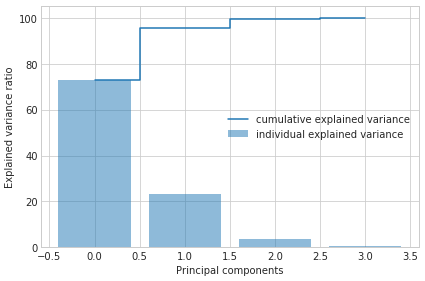

In [23]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(4), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

The plot above clearly shows that most of the variance (72.77% of the variance to be precise) can be explained by the first principal component alone. The second principal component still bears some information (23.03%) while the third and fourth principal components can safely be dropped without losing to much information. Together, the first two principal components contain 95.8% of the information.

### Projection Matrix

Now that we have the principal components we wish to use, while also maintaining a high percentageof explained variance, we may move forward to constructing the projection matrix $\textbf{W}$. The construction of the projection matrix that will be used to transform the Iris data onto the new feature subspace. Although, the name “projection matrix” has a nice ring to it, it is basically just a matrix of our concatenated top $k$ eigenvectors. Recall that the columns of $\textbf{U}$ from the SVD of the correlation matrix consitst of our eigenvectors. So we can concatenate $\textbf{U}$ with the first two columns as we are reducing the dimensionality to the first two principal components.

In [27]:
matrix_w = u[:,[0,1]]
print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.52237162 -0.37231836]
 [ 0.26335492 -0.92555649]
 [-0.58125401 -0.02109478]
 [-0.56561105 -0.06541577]]


### Projection Onto the New Feature Space

Now we will use our projection matrix, $\textbf{W}$ to transform our samples onto the new subspace via:

$\textbf{Y} = \textbf{X} \times \textbf{W}$

In [28]:
Y = X_std.dot(matrix_w)

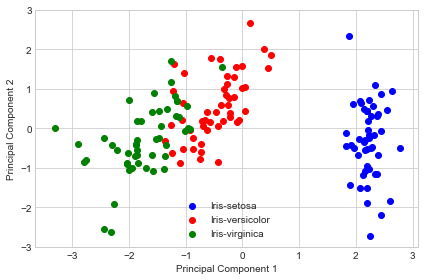

In [30]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

We can see in the plot above that have been able to get almost-perfect separation between the three classes. This is a sign that PCA is really doing a good job at summarizing the
information. It is important to note that PCA is often referred to as an unsupervised algorithm. This is because, attempting to infer what the principal components mean may not make sense. Sometimes the components actually do measure real variables, but sometimes they just reflect patterns of covariance which can have many different causes. 

### The Shortcut Method

As this was the more "Mathematical Approach" to PCA, there is a shortcut with the implementation in scikit-learn.

In [38]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

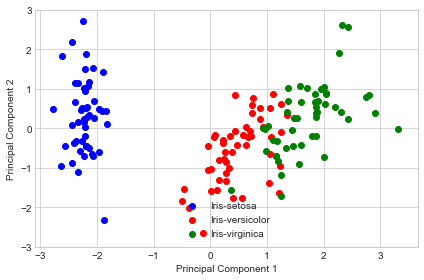

In [39]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
                        ('blue', 'red', 'green')):
        plt.scatter(Y_sklearn[y==lab, 0],
                    Y_sklearn[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

### Conclusion

Dimensionality Reduction plays a really important role in machine learning, especially when you are working with thousands of features. Principal Components Analysis, in addition to making the work of feature manipulation easier, also helps to improve the results of the classifiers, which will be investigated in the future.